<a href="https://colab.research.google.com/github/HardikDk121/Brain-Tumor-Classification/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorflow matplotlib kagglehub --quiet

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
save_path = '/content/drive/MyDrive/my_models'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow recognized the following GPU(s): {gpus}")
    print("NVIDIA CUDA is likely available and configured for TensorFlow.")
else:
    print("No GPU devices found by TensorFlow. Running on CPU.")

TensorFlow recognized the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
NVIDIA CUDA is likely available and configured for TensorFlow.


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brisc2025' dataset.
Path to dataset files: /kaggle/input/brisc2025


In [7]:
!find /kaggle/input/brisc2025 -maxdepth 3

/kaggle/input/brisc2025
/kaggle/input/brisc2025/brisc2025
/kaggle/input/brisc2025/brisc2025/manifest.json
/kaggle/input/brisc2025/brisc2025/README.md
/kaggle/input/brisc2025/brisc2025/segmentation_task
/kaggle/input/brisc2025/brisc2025/segmentation_task/test
/kaggle/input/brisc2025/brisc2025/segmentation_task/train
/kaggle/input/brisc2025/brisc2025/classification_task
/kaggle/input/brisc2025/brisc2025/classification_task/test
/kaggle/input/brisc2025/brisc2025/classification_task/train
/kaggle/input/brisc2025/brisc2025/manifest.csv
/kaggle/input/brisc2025/brisc2025/manifest.json.sha256
/kaggle/input/brisc2025/brisc2025/manifest.csv.sha256


In [ ]:

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
# Define dataset paths and image parameters
# Structure should be:
#   Train/ -> [tumor, notumor]
#   Test/  -> [tumor, notumor]
TRAIN_DIR = '/kaggle/input/brisc2025/brisc2025/classification_task/train'
TEST_DIR = '/kaggle/input/brisc2025/brisc2025/classification_task/test'
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.1 # Slower learning rate for better stability

After mounting, you can save your model to a specific folder in your Google Drive, for example, to a folder named `my_models`:

### 2. Data Preprocessing & Augmentation

In [11]:
# Training Data: Apply augmentation to artificially increase dataset size
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values (0-1)
    rotation_range=10,          # Slight rotation
    width_shift_range=0.1,      # Shift image horizontally
    height_shift_range=0.1,     # Shift image vertically
    shear_range=0.1,            # Shear transformation
    zoom_range=0.1,             # Slight zoom
    horizontal_flip=True,       # Flip horizontally
    fill_mode='nearest'
)

# Testing Data: ONLY rescale. Never augment validation data.
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Images
print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'   ,     # ⚠️ CRITICAL: Use 'binary' for 2 classes
    shuffle=True
)

print("\nLoading Testing Data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'    ,    # ⚠️ CRITICAL: Use 'binary' for 2 classes
    shuffle=False
)

Loading Training Data...
Found 5000 images belonging to 4 classes.

Loading Testing Data...
Found 1000 images belonging to 4 classes.


### 3. Build Binary CNN Architecture

In [10]:
def build_binary_cnn():
    model = Sequential([
        Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),

        # Block 1: Feature Extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2: Deeper Features
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3: Complex Patterns
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flattening
        Flatten(),

        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.5), # Regularization to prevent overfitting

        # Output Layer
        # ⚠️ CRITICAL: 1 neuron with 'sigmoid' for Binary Classification
        Dense(4, activation='softmax')
    ])

    return model

model = build_binary_cnn()

### 4. Compile Model

In [12]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy', # ⚠️ CRITICAL: Loss function for binary tasks
    metrics=['accuracy']
)

# Show architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Train Model

In [13]:
print("\n🚀 Starting Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    verbose=1
)


🚀 Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 106s 632ms/step - accuracy: 0.4491 - loss: 1.2264 - val_accuracy: 0.6583 - val_loss: 0.9271
Epoch 2/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6562 - loss: 0.9241

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6562 - loss: 0.9241 - val_accuracy: 0.6542 - val_loss: 0.9228
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 67s 426ms/step - accuracy: 0.6335 - loss: 0.9243 - val_accuracy: 0.7127 - val_loss: 0.7709
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6250 - loss: 0.6981 - val_accuracy: 0.7127 - val_loss: 0.7302
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 66s 422ms/step - accuracy: 0.6984 - loss: 0.7826 - val_accuracy: 0.7107 - val_loss: 0.7883
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6562 - loss: 0.7439 - val_accuracy: 0.7157 - val_loss: 0.7696
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - accuracy: 0.7356 - loss: 0.6847 - val_accuracy: 0.7359 - val_loss: 0.6825
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7188 - loss: 0.6920 - val_accuracy: 0.7379 - val_loss: 0.6690
Epoch 9/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.7527 - loss: 0.6308 - val_accurac

In [16]:
model.save('/content/drive/MyDrive/my_models/binary_brain_tumor_detector.keras')
print("\n💾 Model saved to Google Drive: '/content/drive/MyDrive/my_models/binary_brain_tumor_detector.keras'")


💾 Model saved to Google Drive: '/content/drive/MyDrive/my_models/binary_brain_tumor_detector.keras'


### 6. Evaluation & Saving

In [17]:
print("\n📊 Evaluating Final Performance...")
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Final Test Loss: {loss:.4f}")

# Save the model for future comparison
model.save('binary_brain_tumor_detector.h5')
print("\n💾 Model saved as 'binary_brain_tumor_detector.h5'")


📊 Evaluating Final Performance...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6987 - loss: 0.6423


✅ Final Test Accuracy: 73.50%
✅ Final Test Loss: 0.6020

💾 Model saved as 'binary_brain_tumor_detector.h5'


### 7. Visualization

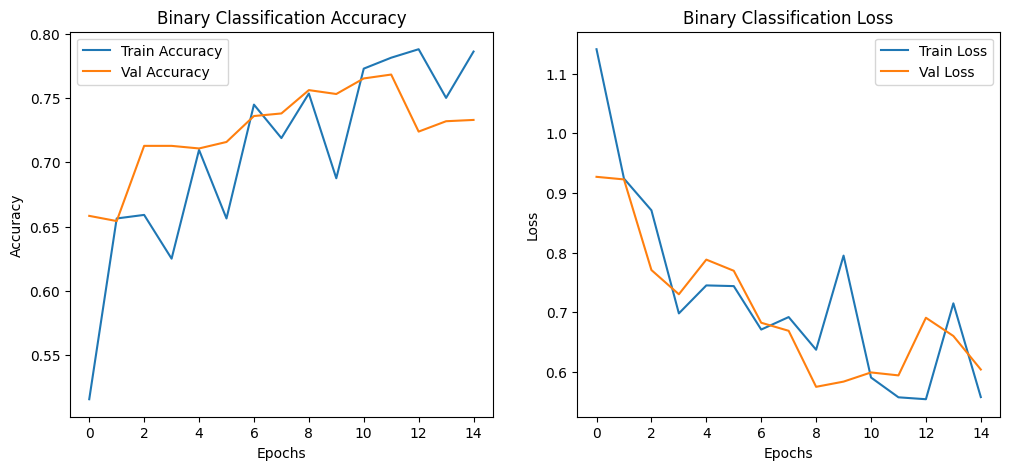

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Multi-Class Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Multi-Class Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()